# **Human activity classification**

### Libraries

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from collections import Counter
from cycler import cycler

from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from time import time

import warnings
warnings.filterwarnings('ignore')

# **Raw data observations**

This dataset contains raw observations data with 

In [3]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
data_raw = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
data_raw

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49106062271000,5.012288,11.264028,0.953424
1,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
2,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
3,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
4,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
...,...,...,...,...,...,...
832895,31,Standing,25207361641000,8.200000,4.520000,0.150000
832896,31,Standing,25207401497000,8.960000,4.020000,1.460000
832897,31,Standing,25207441536000,7.970000,4.750000,0.610000
832898,31,Standing,25207521553000,8.010000,4.790000,0.690000


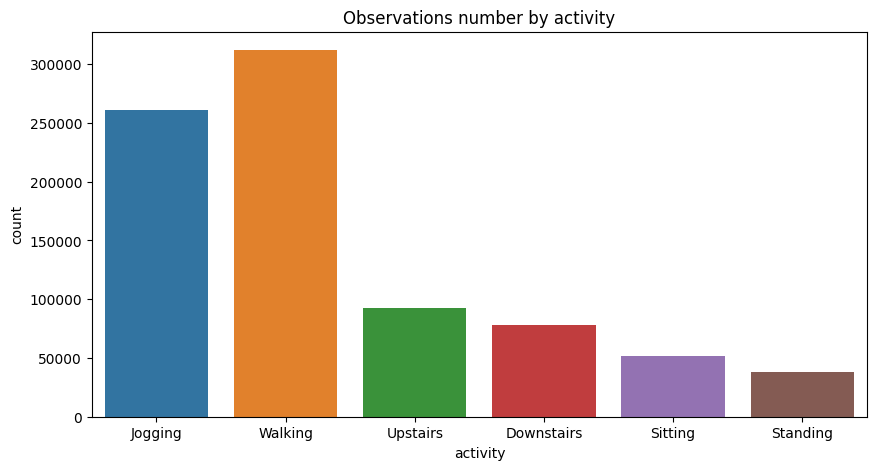

In [4]:
plt.figure(figsize = (10, 5))
sns.countplot(x = 'activity', data = data_raw)
plt.title('Observations number by activity')
plt.show()

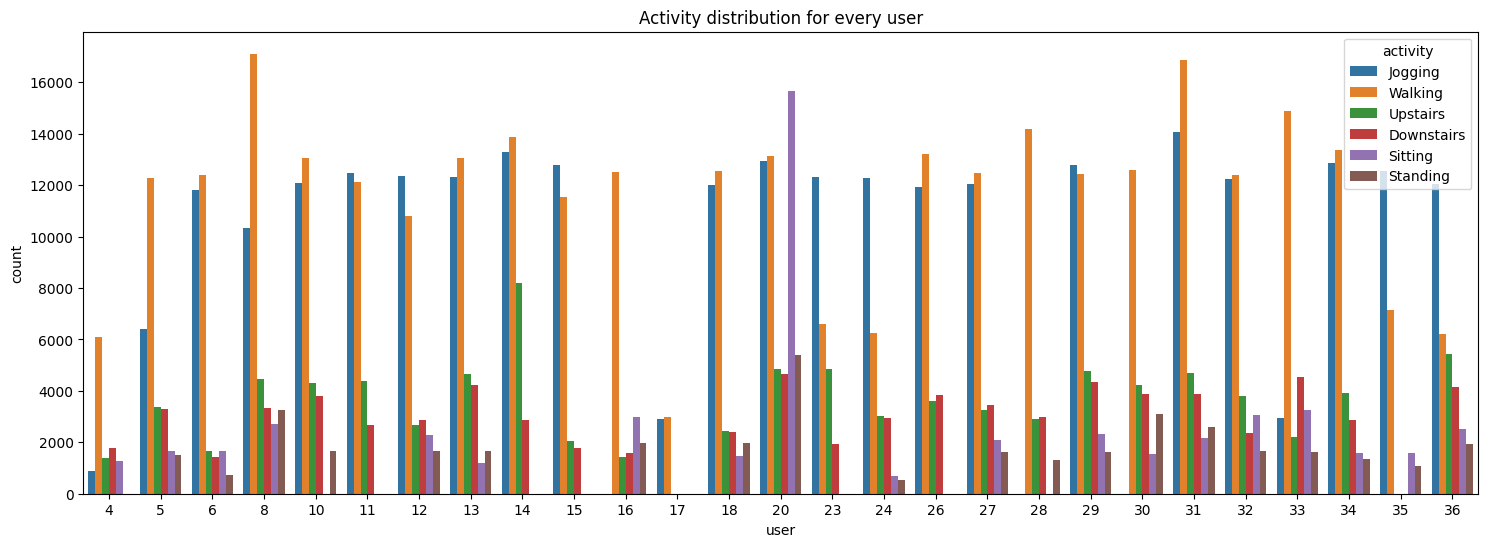

In [5]:
plt.figure(figsize = (18, 6))
sns.countplot(x = 'user', hue = 'activity', data = data_raw)
plt.title('Activity distribution for every user')
plt.show()

### Observations for particular user

Here we plot x, y and z values for one particular user, to see how they change with time (here are taken first 20 seconds for each activity)

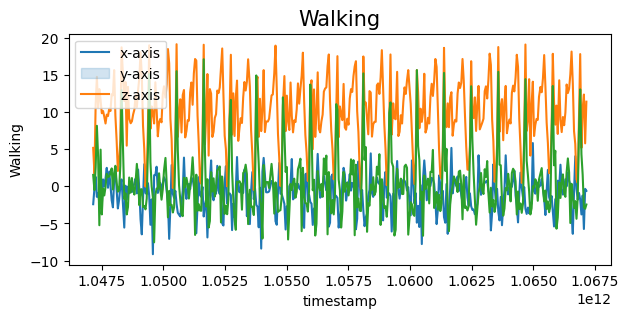

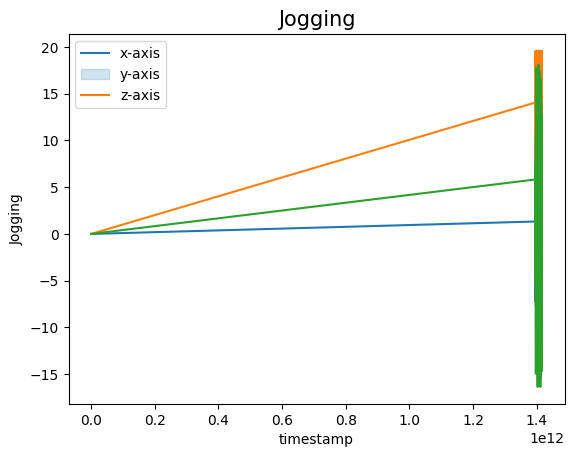

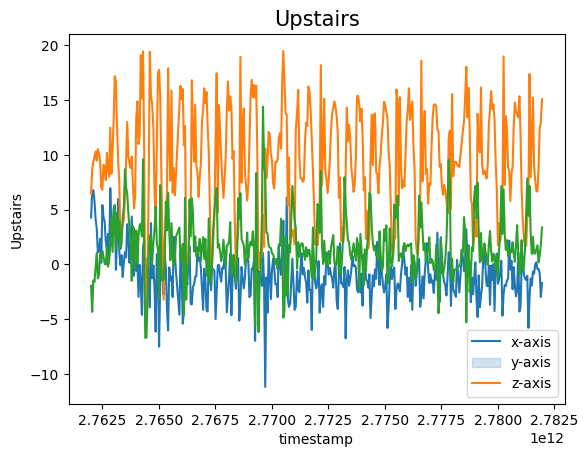

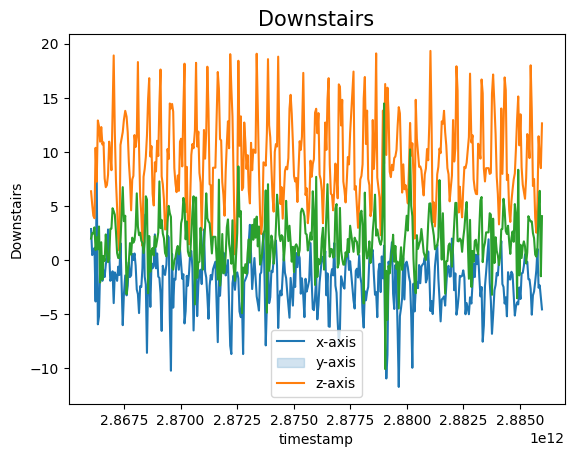

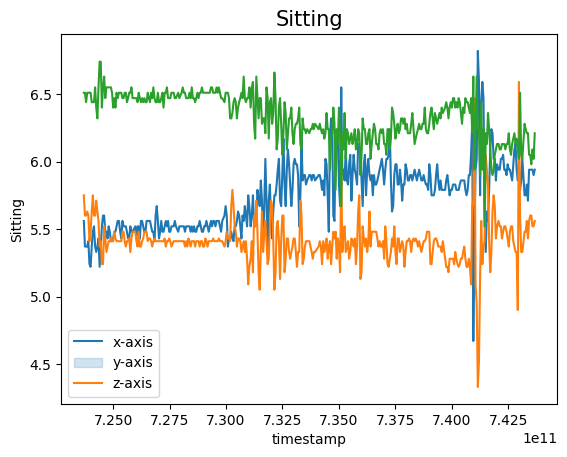

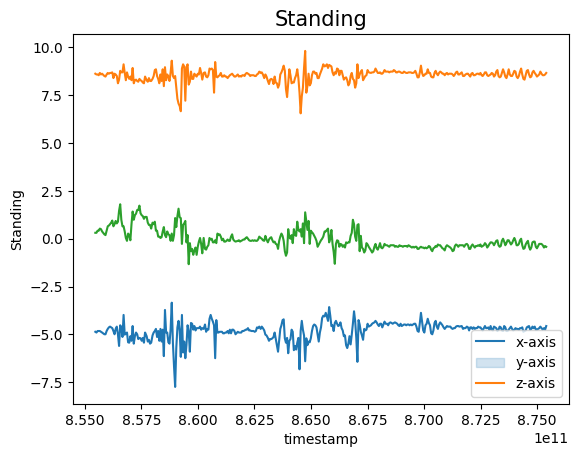

In [6]:
plt.figure(figsize=(7,3)) 

for i in ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']:
    data_13 = data_raw[(data_raw['user'] == 13) & (data_raw['activity'] == i)][:400]
    sns.lineplot(y = 'x-axis', x = 'timestamp', data = data_13)
    sns.lineplot(y = 'y-axis', x = 'timestamp', data = data_13)
    sns.lineplot(y = 'z-axis', x = 'timestamp', data = data_13)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

### Distribution of the signal data along x, y and z axis in terms of different activities

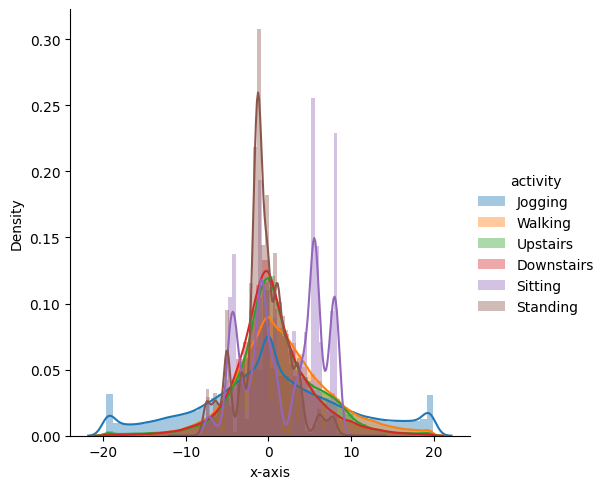

In [7]:
sns.FacetGrid(data_raw, hue = 'activity', height=5).map(sns.distplot, 'x-axis').add_legend()

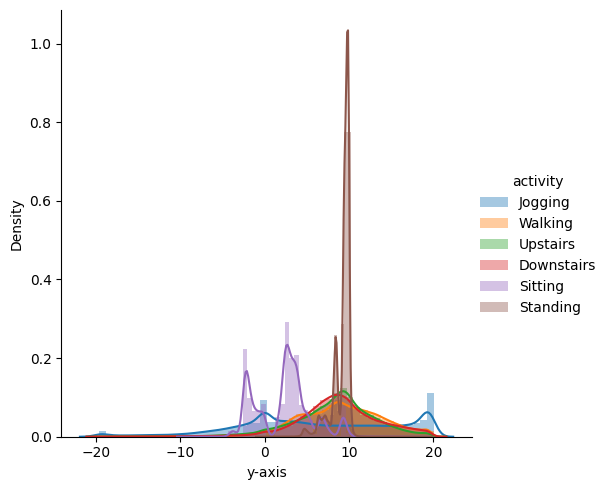

In [8]:
sns.FacetGrid(data_raw, hue = 'activity', height=5).map(sns.distplot, 'y-axis').add_legend()

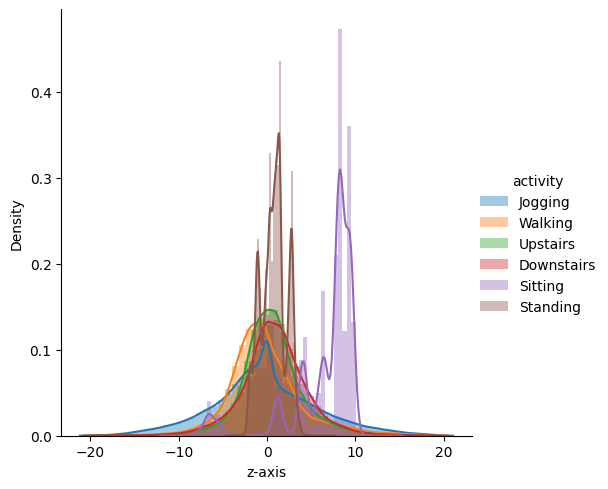

In [9]:
sns.FacetGrid(data_raw, hue = 'activity', height=5).map(sns.distplot, 'z-axis').add_legend()

## Data transformation

In [77]:
from scipy import stats

x_list = []
y_list = []
z_list = []
train_labels = []

window_size = 100
step_size = 50

for i in range(0, data_raw.shape[0] - window_size, step_size):
    xs = data_raw['x-axis'].values[i: i + 100]
    ys = data_raw['y-axis'].values[i: i + 100]
    zs = data_raw['z-axis'].values[i: i + 100]
    label = stats.mode(data_raw['activity'][i: i + 100])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

In [78]:
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

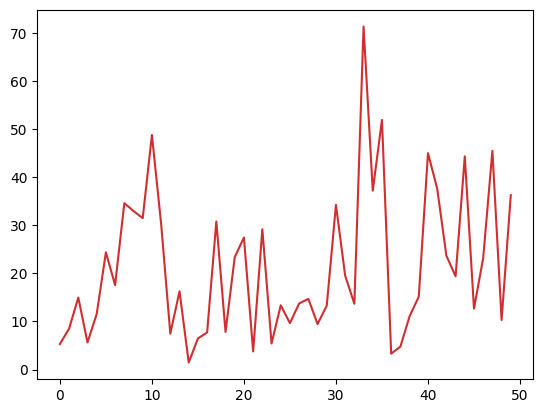

In [81]:
plt.plot(x_list_fft[15])

# **Processed data**

### Data processing

In [10]:
train = pd.read_csv('archive/train.csv')
train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,30,WALKING_UPSTAIRS
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,30,WALKING_UPSTAIRS
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,30,WALKING_UPSTAIRS
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,30,WALKING_UPSTAIRS


In [11]:
train.shape

(7352, 563)

In [12]:
test = pd.read_csv('archive/test.csv')
test.tail()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
2942,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784,24,WALKING_UPSTAIRS
2943,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412,24,WALKING_UPSTAIRS
2944,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184,24,WALKING_UPSTAIRS
2945,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563,24,WALKING_UPSTAIRS
2946,0.153627,-0.018437,-0.137018,-0.330046,-0.195253,-0.164339,-0.430974,-0.218295,-0.229933,-0.111527,...,-0.436940,0.598808,-0.287951,0.876030,-0.024965,-0.660080,0.263936,0.188103,24,WALKING_UPSTAIRS


In [13]:
test.shape

(2947, 563)

## Plotting for one subject

In [14]:
subject_1 = train[train.subject == 1]
subject_1.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


### Standing data

In [15]:
subject_1[subject_1.Activity == 'STANDING'].head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [16]:
num_samples_standing = subject_1[subject_1.Activity == 'STANDING'].shape[0]
num_samples_standing

53

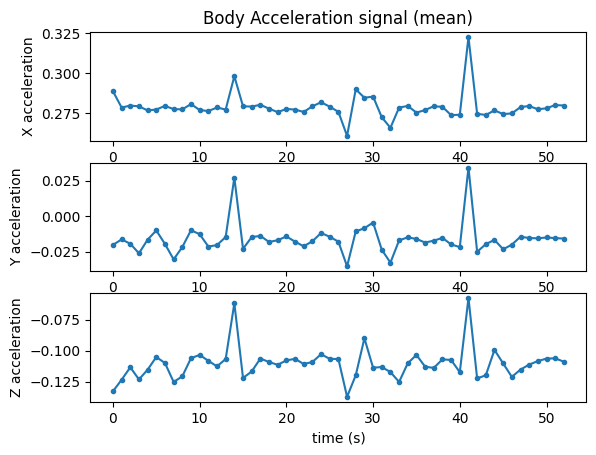

In [17]:
plt.subplot(3, 1, 1)
plt.plot(np.arange(0, num_samples_standing, 1), subject_1[subject_1.Activity == 'STANDING']['tBodyAcc-mean()-X'], '.-')
plt.title('Body Acceleration signal (mean)')
plt.ylabel('X acceleration')

plt.subplot(3, 1, 2)
plt.plot(np.arange(0, num_samples_standing, 1), subject_1[subject_1.Activity == 'STANDING']['tBodyAcc-mean()-Y'], '.-')
plt.xlabel('time (s)')
plt.ylabel('Y acceleration')

plt.subplot(3, 1, 3)
plt.plot(np.arange(0, num_samples_standing, 1), subject_1[subject_1.Activity == 'STANDING']['tBodyAcc-mean()-Z'], '.-')
plt.xlabel('time (s)')
plt.ylabel('Z acceleration')

plt.show()

In [18]:
num_samples_walking = subject_1[subject_1.Activity == 'WALKING'].shape[0]
num_samples_walking

95

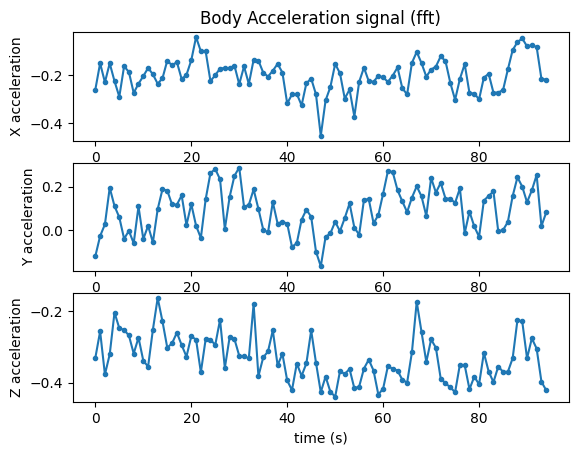

In [19]:
plt.subplot(3, 1, 1)
plt.plot(np.arange(0, num_samples_walking, 1), subject_1[subject_1.Activity == 'WALKING']['fBodyAcc-mean()-X'], '.-')
plt.title('Body Acceleration signal (fft)')
plt.ylabel('X acceleration')

plt.subplot(3, 1, 2)
plt.plot(np.arange(0, num_samples_walking, 1), subject_1[subject_1.Activity == 'WALKING']['fBodyAcc-mean()-Y'], '.-')
plt.xlabel('time (s)')
plt.ylabel('Y acceleration')

plt.subplot(3, 1, 3)
plt.plot(np.arange(0, num_samples_walking, 1), subject_1[subject_1.Activity == 'WALKING']['fBodyAcc-mean()-Z'], '.-')
plt.xlabel('time (s)')
plt.ylabel('Z acceleration')

plt.show()

## EDA

### Cleaning the data (checking for null and duplicates)

In [20]:
print(f'Number of duplicates in train data: {sum(train.duplicated())}')
print(f'Number of duplicates in test data: {sum(test.duplicated())}')
print('---')
print(f'Number of NaN values in train data: {train.isnull().values.sum()}')
print(f'Number of NaN values in test data: {test.isnull().values.sum()}')

Number of duplicates in train data: 0
Number of duplicates in test data: 0
---
Number of NaN values in train data: 0
Number of NaN values in test data: 0


### Data balance

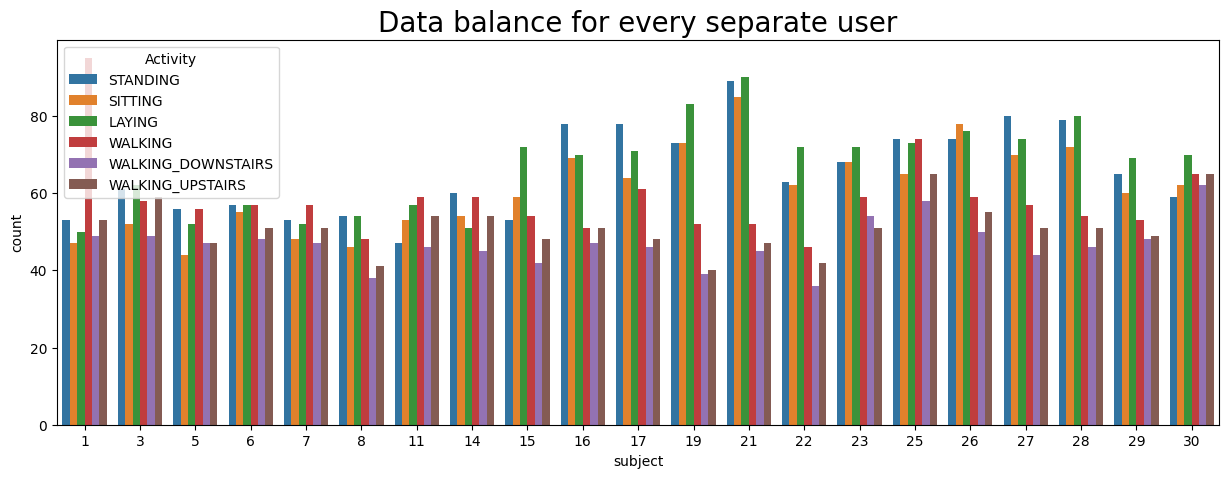

In [21]:
plt.figure(figsize=(15,5))
plt.title('Data balance for every separate user', fontsize=20)
sns.countplot(x='subject', hue='Activity', data = train)
plt.show()

WALKING as 1

WALKING_UPSTAIRS as 2

WALKING_DOWNSTAIRS as 3

SITTING as 4

STANDING as 5

LAYING as 6

In [22]:
train_copy = train.copy()

train_copy.loc[train_copy['Activity'] == 'WALKING', 'Activity'] = 1
train_copy.loc[train_copy['Activity'] == 'WALKING_UPSTAIRS', 'Activity'] = 2
train_copy.loc[train_copy['Activity'] == 'WALKING_DOWNSTAIRS', 'Activity'] = 3
train_copy.loc[train_copy['Activity'] == 'SITTING', 'Activity'] = 4
train_copy.loc[train_copy['Activity'] == 'STANDING', 'Activity'] = 5
train_copy.loc[train_copy['Activity'] == 'LAYING', 'Activity'] = 6

train_copy.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5


In [23]:
test_copy = test.copy()

test_copy.loc[test_copy['Activity'] == 'WALKING', 'Activity'] = 1
test_copy.loc[test_copy['Activity'] == 'WALKING_UPSTAIRS', 'Activity'] = 2
test_copy.loc[test_copy['Activity'] == 'WALKING_DOWNSTAIRS', 'Activity'] = 3
test_copy.loc[test_copy['Activity'] == 'SITTING', 'Activity'] = 4
test_copy.loc[test_copy['Activity'] == 'STANDING', 'Activity'] = 5
test_copy.loc[test_copy['Activity'] == 'LAYING', 'Activity'] = 6

test_copy.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,5
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,5


In [24]:
train_copy['Data'] = 'Train'
test_copy['Data'] = 'Test'
both_df = pd.concat([train_copy, test_copy], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

label = both_df.pop('Activity')

train_copy.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,Train


In [25]:
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts)

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

## TSNE (Explore activities)

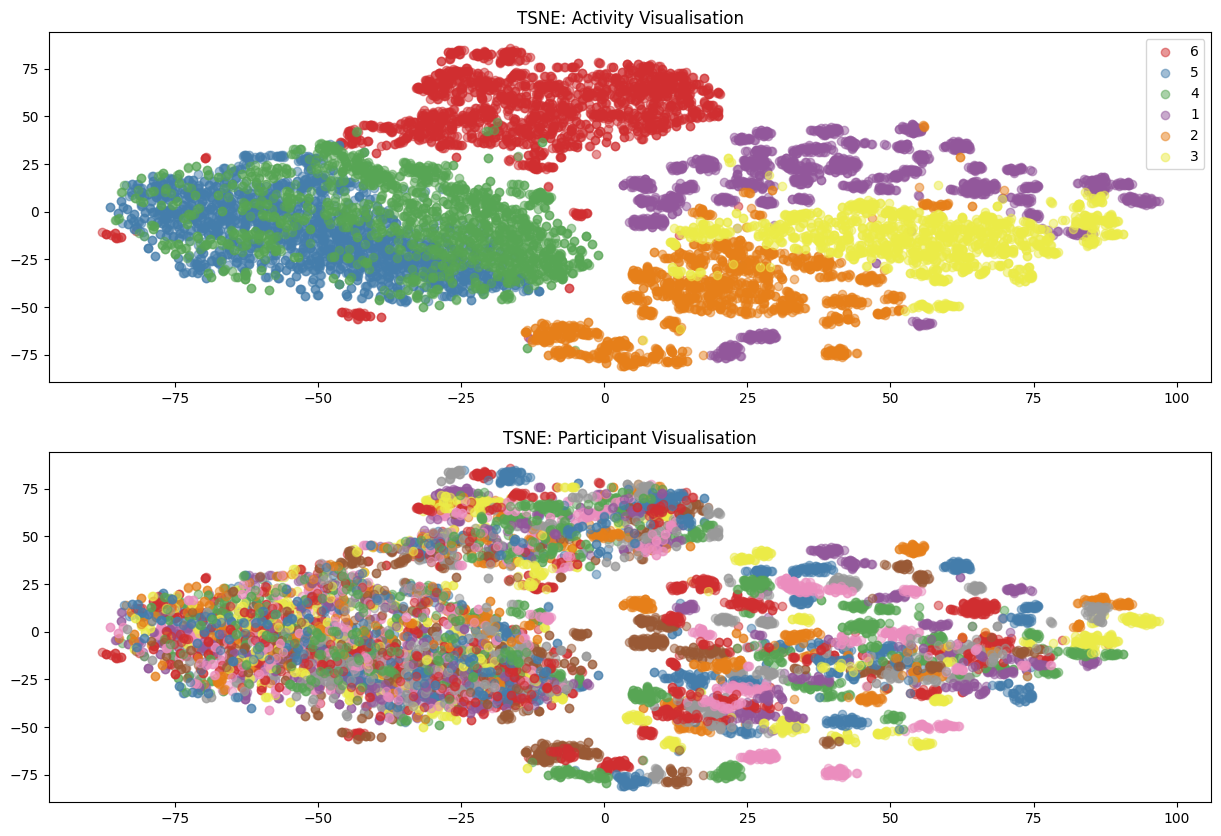

In [40]:
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)

fig, axarr = plt.subplots(2, 1, figsize=(15,10))

for i, group in enumerate(label_counts.index):
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()

for i, group in enumerate(subject_data.unique()):
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

## Prediction with Random Forest Classifier

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

x_train = train_copy.loc[:, ~train_copy.columns.isin(['Activity', 'Data'])]
x_test = test_copy.loc[:, ~train_copy.columns.isin(['Activity', 'Data'])]

y_train = train_copy.Activity.astype('int')
y_test = test_copy.Activity.astype('int')

In [93]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

RandomForestClassifier()

In [94]:
prediction = model.predict(x_test)

In [95]:
confusion_matrix(y_test, prediction)

array([[477,   7,  12,   0,   0,   0],
       [ 34, 430,   7,   0,   0,   0],
       [ 22,  47, 351,   0,   0,   0],
       [  0,   0,   0, 445,  46,   0],
       [  0,   0,   0,  41, 491,   0],
       [  0,   0,   0,   0,   0, 537]])

<AxesSubplot: >

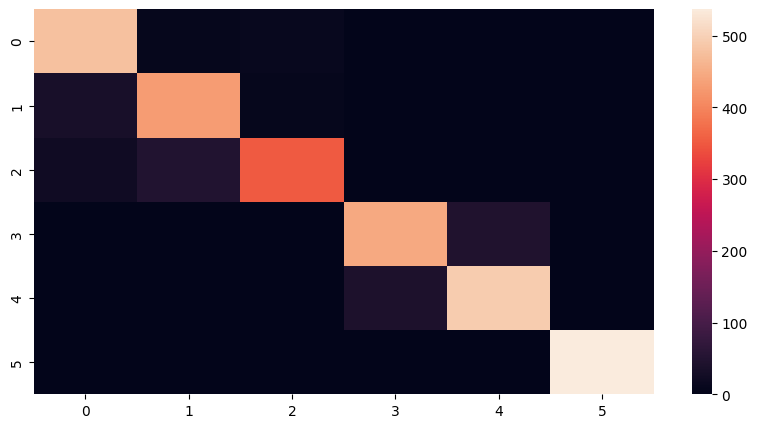

In [96]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, prediction)))

In [82]:
print("Accuracy:", accuracy_score(y_test, prediction))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, prediction))

Accuracy: 0.9250084832032576

 -------------Classification Report-------------

              precision    recall  f1-score   support

           1       0.90      0.97      0.93       496
           2       0.88      0.92      0.90       471
           3       0.97      0.84      0.90       420
           4       0.90      0.90      0.90       491
           5       0.91      0.90      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.92      2947



## Logistic regression

In [97]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [98]:
prediction = model.predict(x_test)

In [99]:
confusion_matrix(y_test, prediction)

array([[486,   6,   4,   0,   0,   0],
       [ 23, 438,  10,   0,   0,   0],
       [  6,   9, 405,   0,   0,   0],
       [  0,   2,   0, 427,  61,   1],
       [  0,   0,   0,  18, 514,   0],
       [  0,   0,   0,   0,   0, 537]])

<AxesSubplot: >

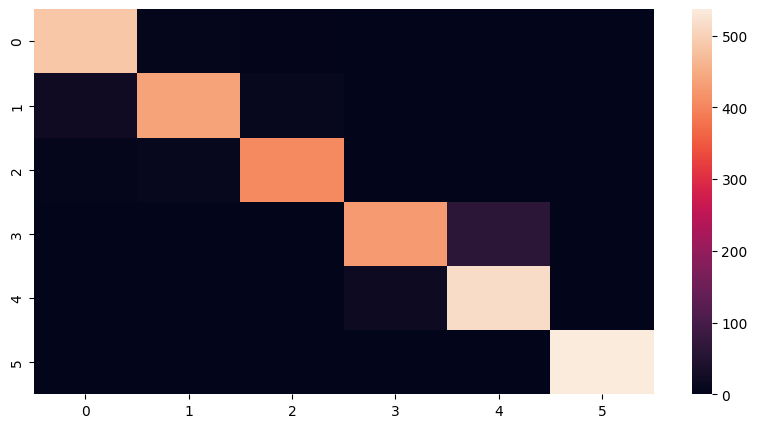

In [100]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, prediction)))